# MODEL IMAGE SEGMENTATION
Data menunjukkan bahwa kerusakan jalan (pothole) memiliki variasi ukuran, bentuk, dan tingkat keparahan yang tinggi, serta sering muncul pada area jalan dengan tekstur visual yang mirip dengan permukaan normal. Selain itu, distribusi data tidak sepenuhnya seimbang antara area rusak dan tidak rusak, sehingga sebagian besar citra didominasi oleh background jalan.

Kondisi ini mengindikasikan bahwa pendekatan klasifikasi saja tidak cukup, karena tidak mampu menunjukkan lokasi dan luasan kerusakan. Oleh karena itu, segmentasi dipilih agar model tidak hanya mendeteksi keberadaan pothole, tetapi juga menyediakan informasi spasial yang relevan untuk mendukung penentuan prioritas perbaikan jalan.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data-science-ara-7-0.zip to data-science-ara-7-0.zip


In [2]:
import zipfile
import io

for filename in uploaded.keys():
    with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')

print("Unzip selesai")

Unzip selesai


In [3]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.4 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
from glob import glob
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import albumentations as A
import segmentation_models_pytorch as smp
from tqdm import tqdm
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt

Penjelasan:
- cv2, albumentations → preprocessing & augmentasi citra
- torch → deep learning framework
- segmentation_models_pytorch → backbone segmentation modern (UNet, FPN, dll)
- KFold → validasi silang (meningkatkan generalisasi model)

In [5]:
SEED = 42
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 30
N_FOLDS = 5
LR = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TRAIN_IMG_DIR  = "/content/dataset/dataset/dataset/train/images"
TRAIN_MASK_DIR = "/content/dataset/dataset/dataset/train/mask"
TEST_IMG_DIR   = "/content/dataset/dataset/dataset/test/images"

MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])

Penjelasan :
- MEAN & STD mengikuti ImageNet normalization, cocok untuk pretrained encoder
- IMG_SIZE = 256 → trade-off optimal antara detail spasial & computational cost
- SEED → penting untuk reproducibility (best practice Kaggle)

In [6]:
# Memastikan hasil eksperimen konsisten
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

Memastikan hasil eksperimen ini konsistem dapat menghindari fluktuasi hasil akibat random initialization

In [7]:
# Membaca data mentah dari disk
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.float32)
    return mask

Penjelasan:
- Mask dibinarisasi → adalah untuk melakukan binary segmentation
- Konversi BGR → RGB penting agar konsisten dengan pretrained model

In [8]:
# Pre Processing (NORMALISASI & RESIZE)
def preprocess_image(img):
    img = img / 255.0
    img = (img - MEAN) / STD
    img = img.transpose(2, 0, 1)
    return img.astype(np.float32)

def preprocess_mask(mask):
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    return mask.astype(np.float32)

Penjelasan:
- Normalisasi mempercepat konvergensi model
- INTER_NEAREST pada mask → mencegah label corruption

In [9]:
# DATA AUGMENTATION
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.03,
        scale_limit=0.08,
        rotate_limit=10,
        border_mode=cv2.BORDER_REFLECT,
        p=0.6
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.15,
        contrast_limit=0.15,
        p=0.4
    ),
    A.Sharpen(
        alpha=(0.1, 0.25),
        lightness=(0.8, 1.0),
        p=0.3
    ),
    A.GaussNoise(
        var_limit=(5.0, 15.0),
        p=0.1
    ),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-539060806.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(


Penjelasan :
- Untuk meningkatkan generalisasi dari model, selain itu dapat menangani variasi dari pencahayaan dan noise, serta augmentasi realistis (tidak over-distort)

In [10]:
# Validation Transform
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
])

In [11]:
# Custom Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx])

        if self.mask_paths is not None:
            mask = read_mask(self.mask_paths[idx])

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img  = augmented["image"]
                mask = augmented["mask"]

            img  = preprocess_image(img)
            mask = preprocess_mask(mask)

            img  = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).float().unsqueeze(0)

            return img, mask

        else:
            if self.transform:
                augmented = self.transform(image=img)
                img = augmented["image"]

            img = preprocess_image(img)
            img = torch.from_numpy(img).float()
            filename = os.path.basename(self.image_paths[idx])

            return img, filename

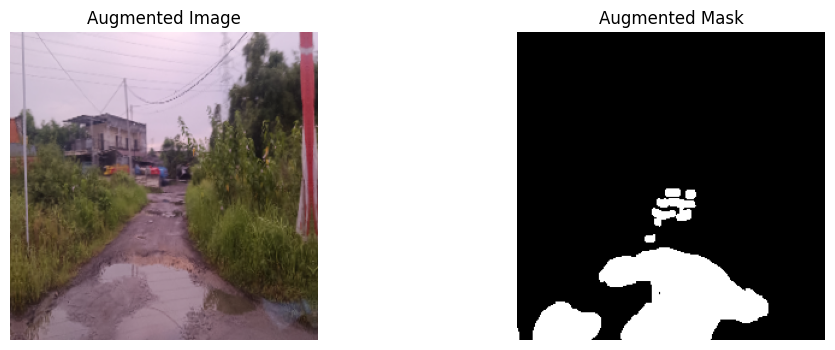

In [12]:
image_paths = sorted(glob(os.path.join(TRAIN_IMG_DIR, "*")))
mask_paths  = sorted(glob(os.path.join(TRAIN_MASK_DIR, "*")))

if not image_paths or not mask_paths:
    raise RuntimeError("Image or mask paths are empty.")

debug_dataset = SegmentationDataset(
    image_paths,
    mask_paths,
    transform=train_transform
)

img_tensor, mask_tensor = debug_dataset[0]

img = img_tensor.numpy().transpose(1,2,0)
mask = mask_tensor.squeeze().numpy()

img = (img * STD + MEAN)
img = np.clip(img, 0, 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Augmented Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Augmented Mask")
plt.axis("off")
plt.show()

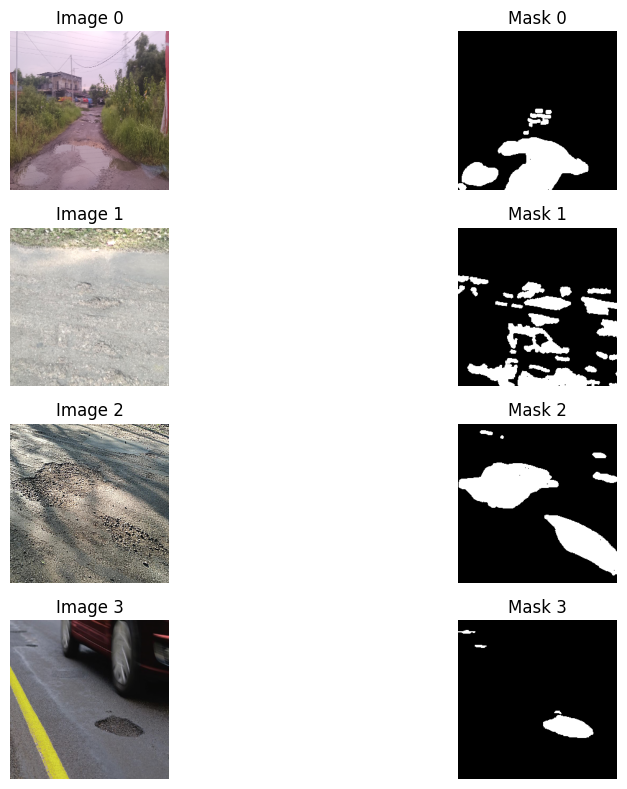

In [13]:
plt.figure(figsize=(12,8))

for i in range(4):
    img, mask = debug_dataset[i]
    img = img.numpy().transpose(1,2,0)
    img = (img * STD + MEAN)
    img = np.clip(img, 0, 1)
    mask = mask.squeeze().numpy()

    plt.subplot(4,2,2*i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i}")

    plt.subplot(4,2,2*i+2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title(f"Mask {i}")

plt.tight_layout()
plt.show()

Visualisasi beberapa sampel menunjukkan variasi ukuran objek dan kompleksitas latar belakang, sehingga diperlukan augmentasi spasial dan intensitas untuk meningkatkan generalisasi model.

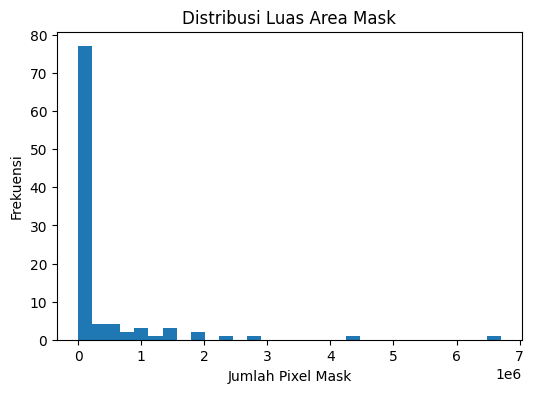

In [14]:
mask_areas = []

for p in mask_paths[:100]:
    m = read_mask(p)
    mask_areas.append(m.sum())

plt.figure(figsize=(6,4))
plt.hist(mask_areas, bins=30)
plt.title("Distribusi Luas Area Mask")
plt.xlabel("Jumlah Pixel Mask")
plt.ylabel("Frekuensi")
plt.show()

Distribusi area mask menunjukkan variasi ukuran objek, yang mengindikasikan potensi ketidakseimbangan antara foreground dan background.

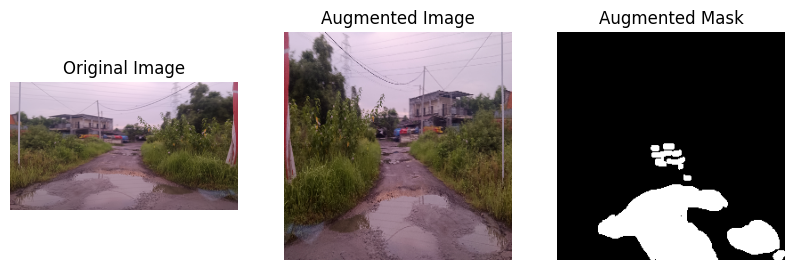

In [15]:
img = read_image(image_paths[0])
mask = read_mask(mask_paths[0])

aug = train_transform(image=img, mask=mask)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(aug["image"])
plt.title("Augmented Image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(aug["mask"], cmap="gray")
plt.title("Augmented Mask")
plt.axis("off")

plt.show()

Augmentasi diterapkan untuk mensimulasikan variasi kondisi nyata tanpa mengubah struktur objek utama pada mask.

Berdasarkan eksplorasi data, preprocessing dan augmentasi yang diterapkan telah disesuaikan dengan karakteristik dataset, khususnya variasi ukuran objek dan kondisi visual. Dengan pipeline data yang stabil dan tervalidasi, tahap selanjutnya difokuskan pada pengembangan dan pelatihan model segmentasi.

# PENGEMBANGAN MODEL SEGMENTASI
Pemilihan model segmentasi berbasis encoder - decoder

In [16]:
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Model yang digunakan adalah U-Net dengan encoder EfficientNet-B3 yang telah dipretrain pada ImageNet.
Pemilihan EfficientNet-B3 didasarkan pada keseimbangan antara:
- kapasitas representasi fitur,
- efisiensi parameter,
- dan stabilitas pelatihan pada dataset berukuran menengah.

Arsitektur U-Net dipilih karena kemampuannya mempertahankan informasi spasial melalui skip-connection, yang krusial dalam tugas segmentasi.

In [17]:
# Definisi Fungsi Loss
dice_loss = smp.losses.DiceLoss(
    mode="binary",
    smooth=1.0
)

bce_loss = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([2.0]).to(DEVICE)
)

def loss_fn(pred, target):
    return 0.7 * dice_loss(pred, target) + 0.3 * bce_loss(pred, target)

Fungsi loss mengombinasikan Dice Loss dan Binary Cross Entropy Loss untuk menangani dua aspek utama:
- Dice Loss memaksimalkan overlap antara prediksi dan ground truth.
- BCE Loss membantu stabilitas optimasi dan penalti kesalahan pixel-wise.

Pemberian bobot lebih besar pada Dice Loss membantu model fokus pada kualitas segmentasi, khususnya pada kondisi ketidakseimbangan foreground–background

In [18]:
# Metrik Evaluasi Dice Score
def dice_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()

    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)

    dice = (2 * intersection + 1e-7) / (union + 1e-7)
    return dice.mean().item()

In [19]:
# Fungsi Training per Epoch
def train_one_epoch(loader, model, optimizer, scaler):
    model.train()
    total_loss = 0

    for images, masks in loader:
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

Training dilakukan menggunakan Automatic Mixed Precision (AMP) untuk:
- mempercepat proses training,
- mengurangi konsumsi memori GPU,
- menjaga stabilitas numerik.

Gradient clipping diterapkan untuk mencegah exploding gradient dan meningkatkan kestabilan pelatihan

In [20]:
# Fungsi Validasi
def valid_one_epoch(loader, model):
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(DEVICE)
            masks  = masks.to(DEVICE)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            dice = dice_score(outputs, masks)

            total_loss += loss.item()
            total_dice += dice

    return total_loss / len(loader), total_dice / len(loader)

In [21]:
# Treshold Tuning
def find_best_threshold(model, loader):
    model.eval()
    thresholds = np.arange(0.3, 0.7, 0.02)
    best_thr = 0
    best_score = 0

    with torch.no_grad():
        for thr in thresholds:
            total_dice = 0

            for images, masks in loader:
                images = images.to(DEVICE)
                masks  = masks.to(DEVICE)

                outputs = torch.sigmoid(model(images))
                preds = (outputs > thr).float()

                intersection = (preds * masks).sum()
                union = preds.sum() + masks.sum()
                dice = (2 * intersection + 1e-7) / (union + 1e-7)

                total_dice += dice.item()

            avg_dice = total_dice / len(loader)

            if avg_dice > best_score:
                best_score = avg_dice
                best_thr = thr

    return best_thr, best_score

Menggunakan threshold default, untuk pencarian threshold optimal demi memaksimalkan Dice Score pada data validasi.
Pendekatan ini membantu meningkatkan performa inferensi tanpa mengubah bobot dari model.

In [22]:
# Cross Validation Setup
kf = KFold(
    n_splits=N_FOLDS,
    shuffle=True,
    random_state=SEED
)

fold_thresholds = []
fold_scores = []

In [23]:
# Dataset & Dataloader
for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):

    train_dataset = SegmentationDataset(
        [image_paths[i] for i in train_idx],
        [mask_paths[i] for i in train_idx],
        transform=train_transform
    )

    val_dataset = SegmentationDataset(
        [image_paths[i] for i in val_idx],
        [mask_paths[i] for i in val_idx],
        transform=val_transform
    )

In [24]:
train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )

val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

In [25]:
for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):

    print(f"\n========== FOLD {fold} ==========")
    set_seed(SEED + fold)

    model = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LR,
        weight_decay=1e-4
    )

    scaler = GradScaler()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=EPOCHS
    )

    best_dice = 0
    patience = 6
    counter = 0

    for epoch in range(EPOCHS):

        train_loss = train_one_epoch(
            train_loader, model, optimizer, scaler
        )

        val_loss, val_dice = valid_one_epoch(
            val_loader, model
        )

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']

        print(f"""
Epoch {epoch+1}
Train Loss : {train_loss:.4f}
Val Loss   : {val_loss:.4f}
Val Dice   : {val_dice:.4f}
LR         : {current_lr:.6f}
""")

        if val_dice > best_dice:
            best_dice = val_dice

            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "dice": best_dice,
                "epoch": epoch
            }, f"best_model_fold_{fold}.pth")

            counter = 0
            print("saved best model")

        else:
            counter += 1

        if counter >= patience:
            print(" early stopping")
            break

    # LOAD BEST MODEL
    ckpt = torch.load(f"best_model_fold_{fold}.pth")
    model.load_state_dict(ckpt["model"])

    fold_scores.append(ckpt["dice"])

    # THRESHOLD TUNING
    best_thr, best_score = find_best_threshold(
        model, val_loader
    )

    fold_thresholds.append(best_thr)

    print(f"Best threshold fold {fold}: {best_thr:.3f}")
    print(f"Best dice fold {fold}: {ckpt['dice']:.4f}")


========== FOLD 0 ==========


/tmp/ipython-input-2877788292.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-1412719881.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1
Train Loss : 0.6739
Val Loss   : 0.5342
Val Dice   : 0.5840
LR         : 0.000299

saved best model

Epoch 2
Train Loss : 0.4807
Val Loss   : 0.4049
Val Dice   : 0.6276
LR         : 0.000297

saved best model

Epoch 3
Train Loss : 0.3782
Val Loss   : 0.3373
Val Dice   : 0.6397
LR         : 0.000293

saved best model

Epoch 4
Train Loss : 0.3062
Val Loss   : 0.3118
Val Dice   : 0.6382
LR         : 0.000287


Epoch 5
Train Loss : 0.2662
Val Loss   : 0.2603
Val Dice   : 0.6646
LR         : 0.000280

saved best model

Epoch 6
Train Loss : 0.2695
Val Loss   : 0.2602
Val Dice   : 0.6648
LR         : 0.000271

saved best model

Epoch 7
Train Loss : 0.2321
Val Loss   : 0.2792
Val Dice   : 0.6301
LR         : 0.000261


Epoch 8
Train Loss : 0.2310
Val Loss   : 0.2372
Val Dice   : 0.6592
LR         : 0.000250


Epoch 9
Train Loss : 0.2040
Val Loss   : 0.2311
Val Dice   : 0.6870
LR         : 0.000238

saved best model

Epoch 10
Train Loss : 0.1790
Val Loss   : 0.2312
Val Dice   : 0.6872


In [26]:
final_threshold = np.mean(fold_thresholds)
print("Final threshold:", final_threshold)

Final threshold: 0.5720000000000003


Threshold akhir diperoleh dari rata-rata threshold terbaik tiap fold validasi.
Pendekatan ini mengurangi bias terhadap satu fold tertentu dan menghasilkan nilai ambang yang lebih stabil untuk generalisasi pada data test yang tidak berlabel.

In [27]:
import os

print("Isi folder test:")
print(os.listdir("/content/dataset/dataset/dataset/test/images")[:10])


Isi folder test:
['test_027.jpg', 'test_218.jpg', 'test_116.jpg', 'test_074.jpg', 'test_201.jpg', 'test_087.jpg', 'test_296.jpg', 'test_037.jpg', 'test_035.jpg', 'test_209.jpg']


In [28]:
# Load Model terbaik dari setiap fold (Ensemble)
models = []

for fold in range(N_FOLDS):

    model = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(DEVICE)

    ckpt = torch.load(f"best_model_fold_{fold}.pth", map_location=DEVICE)

    if "model" in ckpt:
        model.load_state_dict(ckpt["model"])
    else:
        model.load_state_dict(ckpt)

    model.eval()
    models.append(model)

print("Loaded models:", len(models))

Loaded models: 5


In [29]:
# Validasi Ulang Direktori Test
print("TEST_IMG_DIR =", TEST_IMG_DIR)
print("exists:", os.path.exists(TEST_IMG_DIR))
print("files:", os.listdir(TEST_IMG_DIR)[:10])

TEST_IMG_DIR = /content/dataset/dataset/dataset/test/images
exists: True
files: ['test_027.jpg', 'test_218.jpg', 'test_116.jpg', 'test_074.jpg', 'test_201.jpg', 'test_087.jpg', 'test_296.jpg', 'test_037.jpg', 'test_035.jpg', 'test_209.jpg']


Pemeriksaan ulang ini berfungsi sebagai safety check untuk memastikan pipeline inferensi tidak gagal akibat kesalahan path.

In [30]:
# Load Seluruh Gambar Test
from glob import glob
import os

TEST_IMG_DIR = "/content/dataset/dataset/dataset/test/images"

test_images = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))

print("Total test images:", len(test_images))
print(test_images[:5])

Total test images: 295
['/content/dataset/dataset/dataset/test/images/test_001.jpg', '/content/dataset/dataset/dataset/test/images/test_002.jpg', '/content/dataset/dataset/dataset/test/images/test_003.jpg', '/content/dataset/dataset/dataset/test/images/test_004.jpg', '/content/dataset/dataset/dataset/test/images/test_005.jpg']


In [31]:
# Inference dengan Ensemble + Test Time Augmentation
pred_masks = []

with torch.no_grad():
    for img_path in test_images:
        img = read_image(img_path)
        original_size = (img.shape[1], img.shape[0])

        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_tensor = preprocess_image(img_resized)
        img_tensor = torch.tensor(img_tensor).unsqueeze(0).to(DEVICE)

        pred_sum = 0

        for model in models:

            p1 = torch.sigmoid(model(img_tensor))

            hflip = torch.flip(img_tensor, dims=[3])
            p2 = torch.sigmoid(model(hflip))
            p2 = torch.flip(p2, dims=[3])

            vflip = torch.flip(img_tensor, dims=[2])
            p3 = torch.sigmoid(model(vflip))
            p3 = torch.flip(p3, dims=[2])

            model_pred = (p1 + p2 + p3) / 3
            pred_sum += model_pred

        pred = pred_sum / len(models)
        pred = pred[0,0].cpu().numpy()

        mask = (pred > final_threshold).astype("uint8") * 255
        mask = cv2.resize(mask, original_size, interpolation=cv2.INTER_NEAREST)

        pred_masks.append(mask)

print("Pred masks:", len(pred_masks))

Pred masks: 295


Inferensi dilakukan menggunakan ensemble multi-fold yang dikombinasikan dengan Test Time Augmentation (horizontal & vertical flip).
Pendekatan ini meningkatkan robustness model terhadap variasi orientasi objek dan membantu menghasilkan segmentasi yang lebih konsisten.

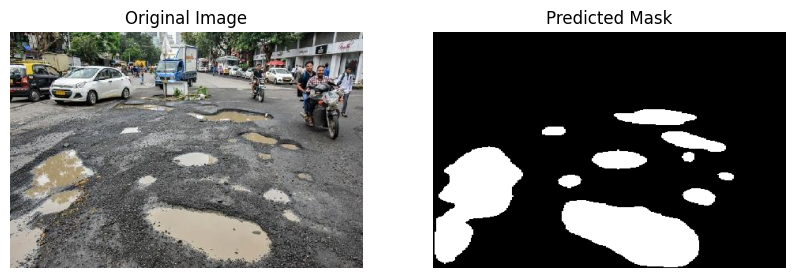

In [32]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(test_images))

img = read_image(test_images[idx])
mask = pred_masks[idx]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()

Visualisasi ini digunakan untuk evaluasi kualitatif hasil segmentasi, memastikan bahwa mask yang dihasilkan selaras secara spasial dengan objek pada citra asli. dan terlihat jika image pada data test selaras dengan mask yang dihasilkan

In [33]:
# Encoding Mask ke RLE
def encode_rle(mask):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[0::2]
    return " ".join(str(x) for x in runs)

In [34]:
# Safety Check & Submission File
print("test_images :", len(test_images))
print("pred_masks  :", len(pred_masks))

assert len(test_images) == len(pred_masks), "Jumlah image & mask tidak sama!"

test_images : 295
pred_masks  : 295


In [35]:
rles = []

for mask in pred_masks:
    if mask.sum() == 0:
        rles.append("")
    else:
        rles.append(encode_rle(mask))

submission = pd.DataFrame({
    "ImageId": [os.path.basename(p) for p in test_images],
    "rle": rles
})

submission.to_csv("submission_final.csv", index=False)

print("Submission saved")
print("Total images :", len(test_images))
print("Total rle    :", submission["rle"].notna().sum())
print("Empty masks  :", (submission["rle"] == "").sum())

Submission saved
Total images : 295
Total rle    : 295
Empty masks  : 2


# Interpretasi & Desicion Making
Pengembangan model segmentasi pothole dilakukan sebagai respons atas keterbatasan data kerusakan jalan yang masih bersifat manual, tidak terstruktur, dan lambat diperbarui. Tantangan ini menuntut solusi berbasis data visual yang mampu mengidentifikasi pothole secara konsisten dan objektif.

Model U-Net dengan encoder EfficientNet dipilih karena mampu menangkap detail kerusakan jalan sekaligus tetap stabil pada keterbatasan data. Validasi berbasis K-Fold dan ensemble digunakan untuk memastikan keputusan model tidak bergantung pada satu skenario data. Threshold ditentukan dari hasil validasi agar prediksi dapat langsung digunakan dalam konteks operasional.

Keputusan akhir ini memungkinkan hasil model dimanfaatkan sebagai dasar prioritisasi perbaikan jalan, sehingga proses pengambilan keputusan tidak lagi bergantung pada laporan manual, tetapi pada analisis data yang terukur dan dapat dipertanggungjawabkan.